In [1]:
# STEP 1
# Load the filtered gene-expression dataset and prepare X (features) and y (labels)

import pandas as pd
import re

# Load Excel file 
file_path = "filtered_genes_adj_pval_below_0.1.xlsx"   # adjust path if needed
df_raw = pd.read_excel(file_path)


# Identify sample columns 
# Keep columns whose names match the pattern "P<number>-N" or "P<number>-T"
sample_cols = [c for c in df_raw.columns if re.match(r"^P\d+[-][NT]$", c)]

# Extract just the expression matrix (genes × samples) and gene names
expr_mat = df_raw[sample_cols]
gene_names = df_raw['Gene'] if 'Gene' in df_raw.columns else df_raw.index

# Transpose so rows = samples, columns = genes 
X = expr_mat.T.copy()
X.columns = gene_names

# labeling tumor as 1 and normal as 0
# Tumour samples end with "-T"  →  label = 1
# Normal samples end with "-N"  →  label = 0
y = X.index.str.endswith('-T').astype(int)

# Clean sample IDs (remove -N / -T suffix) for readability
X.index = X.index.str.replace(r'-[NT]$', '', regex=True)

#  printing output
print("Shape of X  (samples × genes):", X.shape)
print("Number of cancer samples   (y=1):", (y == 1).sum())
print("Number of healthy samples  (y=0):", (y == 0).sum())
print(X)


Shape of X  (samples × genes): (52, 9382)
Number of cancer samples   (y=1): 26
Number of healthy samples  (y=0): 26
Gene   A1BG-AS1         A1CF      A2ML1       AA06    AADACL3    AADACL4  \
P1    35.126818    26.425869  26.818042  17.153285  58.203500  21.963225   
P1    31.405863    17.903056  25.650144  13.572607  44.239648  15.445814   
P2    36.842856    45.553216  25.585473  14.757536  52.182530  21.750927   
P2    55.727982   774.337660  26.090668  16.934623  57.029600  22.200711   
P3    39.275807    44.171656  28.737666  14.583560  46.818961  20.852725   
P3    39.248783    31.607631  30.647298  14.749488  64.463785  21.503685   
P4    47.696880    61.465928  26.931226  14.061017  58.562369  24.760079   
P4    37.243532  1157.404947  25.527405  13.025574  59.111872  25.728439   
P5    36.047442   155.684122  25.834409  14.392677  55.112054  25.250534   
P5     0.000000     0.000000   0.000000   0.000000   0.000000   0.000000   
P6    52.159459    86.857228  29.238634  14.5495

In [2]:
# STEP 2 
# Split the data into training and test sets

from sklearn.model_selection import train_test_split

# Split: 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,         # 20% test set → about 10–11 samples
    stratify=y,             # keep class ratio equal in both sets
    random_state=42         # for reproducibility
)
feat_order = list(X_train.columns)       # X_train is the DataFrame you trained on
pd.Series(feat_order).to_csv("gene_feature_order.txt", index=False, header=False)

# Check shapes and class counts
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("Training set — Cancer:", (y_train == 1).sum(), "Healthy:", (y_train == 0).sum())
print("Test set     — Cancer:", (y_test == 1).sum(), "Healthy:", (y_test == 0).sum())


X_train shape: (41, 9382)
X_test  shape: (11, 9382)
Training set — Cancer: 21 Healthy: 20
Test set     — Cancer: 5 Healthy: 6


## 🌳 Model 1: Logistic regression with selectKbest


In [3]:
# STEP 3 ──────────────────────────────────────────────────────────────
# Build the ML pipeline: Feature Selection → Scaling → Classification for LOGISTIC REGRESSION

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Build pipeline
pipe = Pipeline([
    ('select', SelectKBest(score_func=f_classif)),         # Select top k genes
    ('scale', StandardScaler()),                           # Normalize gene expression
    ('clf', LogisticRegression(max_iter=1000,               # Classifier
                               class_weight='balanced',     # Handle class imbalance
                               solver='liblinear'))         # Good for small datasets
])

# Display the pipeline structure
pipe


Pipeline(steps=[('select', SelectKBest()), ('scale', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [4]:
# STEP 4 ──────────────────────────────────────────────────────────────
# Perform grid search to find the best number of genes (k) and model regularization (C)

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define parameter grid to test different values of k and C
param_grid = {
    'select__k': [500, 1000, 2000],         # Number of genes to keep
    'clf__C': [0.01, 0.1, 1, 10]       # Inverse of regularization strength
}

# 5-fold cross-validation with class balance preserved
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV to find best combination of k and C
grid = GridSearchCV(
    estimator=pipe,              # the pipeline we built earlier
    param_grid=param_grid,
    scoring='roc_auc',           # performance metric: AUC
    cv=cv,
    n_jobs=-1,                   # use all CPU cores
    verbose=1
)

# Fit grid search on training data
grid.fit(X_train, y_train)

# Show best parameters and best score
print("Best parameters:", grid.best_params_)
print("Best cross-validated ROC-AUC score:", grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'clf__C': 0.1, 'select__k': 1000}
Best cross-validated ROC-AUC score: 0.8525


              precision    recall  f1-score   support

     Healthy       0.67      1.00      0.80         6
      Cancer       1.00      0.40      0.57         5

    accuracy                           0.73        11
   macro avg       0.83      0.70      0.69        11
weighted avg       0.82      0.73      0.70        11

Test ROC-AUC Score: 0.7167


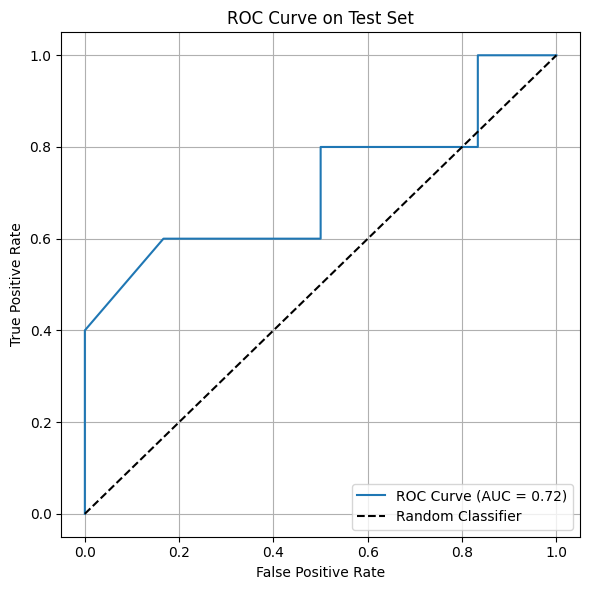

In [5]:
# STEP 5 ──────────────────────────────────────────────────────────────
# Evaluate the best model on the test set and plot the ROC curve

from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Predict probability for the positive class (cancer = 1)
y_proba = grid.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = grid.predict(X_test)              # Final predictions

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
test_auc = roc_auc_score(y_test, y_proba)

# Print classification report and AUC
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Cancer']))
print("Test ROC-AUC Score:", round(test_auc, 4))

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



Classification report with threshold = 0.4
              precision    recall  f1-score   support

     Healthy       0.67      0.67      0.67         6
      Cancer       0.60      0.60      0.60         5

    accuracy                           0.64        11
   macro avg       0.63      0.63      0.63        11
weighted avg       0.64      0.64      0.64        11

Test ROC-AUC Score (probability-based): 0.7167


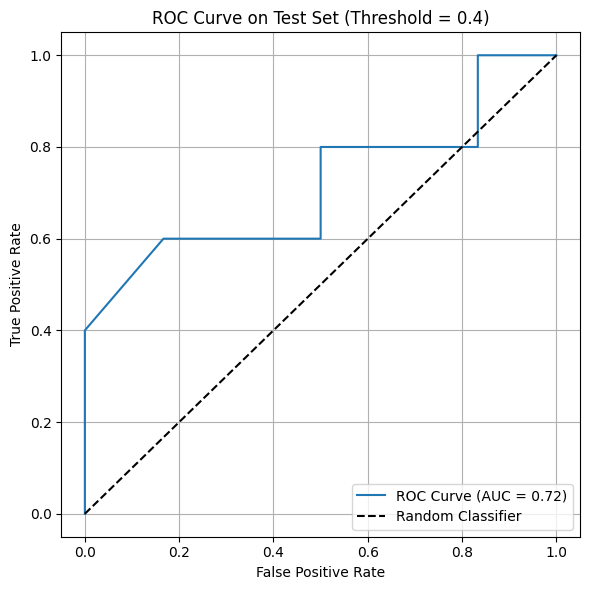

In [6]:
# STEP 6 ──────────────────────────────────────────────────────────────
# Lower threshold and re-evaluate with ROC and classification metrics

from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Use predicted probabilities from test set
# y_proba already exists from Step 5: grid.predict_proba(X_test)[:, 1]

# Set custom threshold
threshold = 0.4
y_pred_custom = (y_proba >= threshold).astype(int)

# Classification report
print(f"\nClassification report with threshold = {threshold}")
print(classification_report(y_test, y_pred_custom, target_names=['Healthy', 'Cancer']))

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
test_auc = roc_auc_score(y_test, y_proba)
print("Test ROC-AUC Score (probability-based):", round(test_auc, 4))

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve on Test Set (Threshold = {threshold})")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()




## 🌳 Model 2: Random Forest Classifier (All Genes, No Feature Selection)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create pipeline with only the classifier
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Print to verify structure
rf_pipe


Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [8]:
# Define the hyperparameter grid to tune for Random Forest
param_grid_rf = {
    # Number of trees in the forest
    'clf__n_estimators': [100, 300, 500],

    # Maximum depth of each tree (None = expand until all leaves are pure)
    'clf__max_depth': [None, 10, 20],

    # Minimum number of samples required to be at a leaf node
    'clf__min_samples_leaf': [1, 2, 4]
}


In [9]:
# STEP 4 ──────────────────────────────────────────────────────────────
# Perform grid search to find the best Random Forest hyperparameters

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define parameter grid to test different Random Forest settings
param_grid_rf = {
    'clf__n_estimators': [100, 300, 500],    # Number of trees in the forest
    'clf__max_depth': [None, 10, 20],        # Maximum depth of the trees
    'clf__min_samples_leaf': [1, 2, 4]       # Minimum number of samples in a leaf
}

# 5-fold cross-validation with class balance preserved
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV to find best combination of RF hyperparameters
grid_rf = GridSearchCV(
    estimator=rf_pipe,              # the pipeline we built earlier
    param_grid=param_grid_rf,
    scoring='roc_auc',              # performance metric: AUC
    cv=cv,
    n_jobs=-1,                      # use all CPU cores
    verbose=1
)

# Fit grid search on training data
grid_rf.fit(X_train, y_train)

# Show best parameters and best score
print("Best parameters:", grid_rf.best_params_)
print("Best cross-validated ROC-AUC score:", grid_rf.best_score_)



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100}
Best cross-validated ROC-AUC score: 0.8074999999999999


Classification Report (Test Set):
              precision    recall  f1-score   support

     Healthy       0.67      1.00      0.80         6
       Tumor       1.00      0.40      0.57         5

    accuracy                           0.73        11
   macro avg       0.83      0.70      0.69        11
weighted avg       0.82      0.73      0.70        11

Test ROC-AUC Score: 0.7167


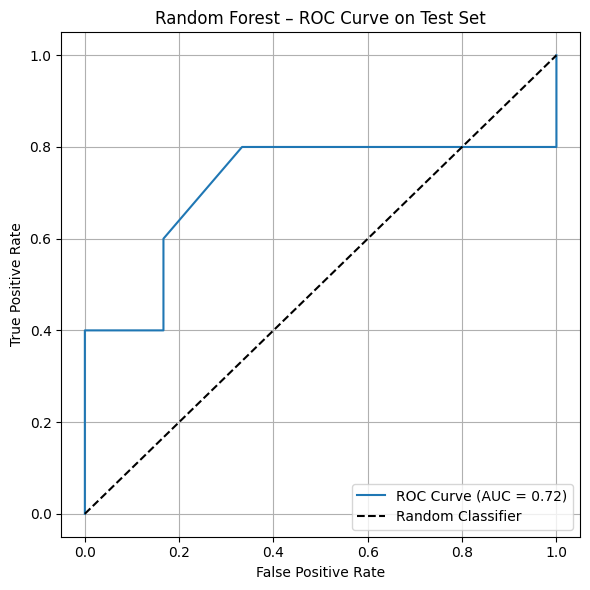

In [10]:
# STEP 5 ──────────────────────────────────────────────────────────────
# Evaluate the best Random Forest model on the test set

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted labels and probabilities for the test set
y_pred_rf = grid_rf.predict(X_test)
y_proba_rf = grid_rf.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (tumor)

# Print classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_rf, target_names=['Healthy', 'Tumor']))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
test_auc_rf = roc_auc_score(y_test, y_proba_rf)

print("Test ROC-AUC Score:", round(test_auc_rf, 4))

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest – ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🌳 Model 3: Random Forest Classifier (with feature selection)

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create a pipeline with SelectFromModel followed by RandomForestClassifier
rf_sfm_pipe = Pipeline([
    # Step 1: Use RandomForest to select important features based on importance scores
    ('select', SelectFromModel(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        threshold='median'  # keep top 50% most important genes
    )),

    # Step 2: Train another RandomForest on the selected genes
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Print to verify structure
rf_sfm_pipe


Pipeline(steps=[('select',
                 SelectFromModel(estimator=RandomForestClassifier(class_weight='balanced',
                                                                  random_state=42),
                                 threshold='median')),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [12]:
# STEP 2 ──────────────────────────────────────────────────────────────
# Tune SelectFromModel + Random Forest in a single block
#   • Define hyperparameter grid
#   • Set up cross-validation
#   • Run GridSearchCV

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1) Hyperparameter grid
param_grid_rf_sfm = {
    # Threshold that decides how many genes to keep
    #   - 'median'  ≈ top 50 %
    #   - 'mean'    ≈ top ~40 %
    #   - numeric   keeps genes with importance ≥ that value
    'select__threshold': ['median', 'mean', 0.001, 0.002],

    # Final Random Forest hyperparameters
    'clf__n_estimators': [100, 300, 500],   # Number of trees
    'clf__max_depth': [None, 10, 20],       # Tree depth (None = full)
    'clf__min_samples_leaf': [1, 2, 4]      # Min samples per leaf
}

# 2) Stratified 5-fold CV (keeps class balance in each fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) GridSearchCV to find the best combo of threshold + RF params
grid_rf_sfm = GridSearchCV(
    estimator=rf_sfm_pipe,          # pipeline defined earlier
    param_grid=param_grid_rf_sfm,   # grid above
    scoring='roc_auc',              # optimize AUC
    cv=cv,
    n_jobs=-1,                      # use all CPU cores
    verbose=1
)

# Fit grid search on training data
grid_rf_sfm.fit(X_train, y_train)

# Show best parameters and best score
print("Best parameters:", grid_rf_sfm.best_params_)
print("Best cross-validated ROC-AUC score:", grid_rf_sfm.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 300, 'select__threshold': 'mean'}
Best cross-validated ROC-AUC score: 0.8225


Classification Report (Test Set):
              precision    recall  f1-score   support

     Healthy       0.67      1.00      0.80         6
       Tumor       1.00      0.40      0.57         5

    accuracy                           0.73        11
   macro avg       0.83      0.70      0.69        11
weighted avg       0.82      0.73      0.70        11

Test ROC-AUC Score: 0.7167


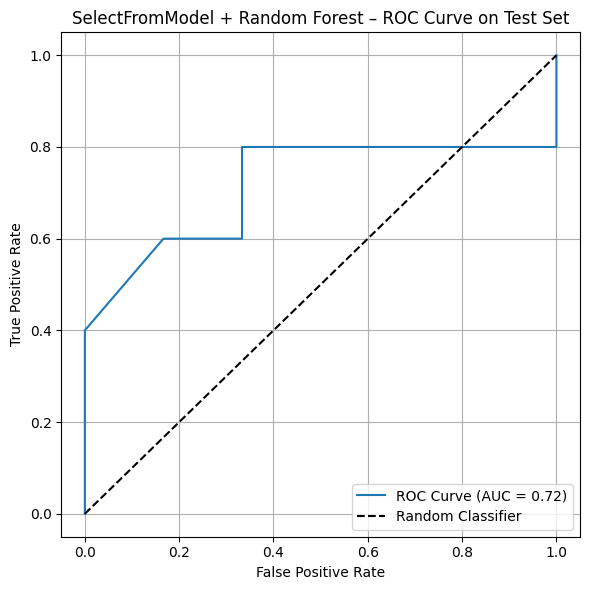

In [13]:
# STEP 3 ──────────────────────────────────────────────────────────────
# Evaluate the best SelectFromModel + Random Forest model on the test set

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict class labels and probabilities for the test set
y_pred_rf_sfm = grid_rf_sfm.predict(X_test)
y_proba_rf_sfm = grid_rf_sfm.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (tumor)

# Print classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred_rf_sfm, target_names=['Healthy', 'Tumor']))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf_sfm)
test_auc_rf_sfm = roc_auc_score(y_test, y_proba_rf_sfm)

print("Test ROC-AUC Score:", round(test_auc_rf_sfm, 4))

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc_rf_sfm:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SelectFromModel + Random Forest – ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



=== RF-all-genes (threshold 0.4) ===
              precision    recall  f1-score   support

     Healthy       0.62      0.83      0.71         6
      Cancer       0.67      0.40      0.50         5

    accuracy                           0.64        11
   macro avg       0.65      0.62      0.61        11
weighted avg       0.64      0.64      0.62        11

ROC-AUC: 0.7167   PR-AUC: 0.7742

=== RF+SFM (threshold 0.4) ===
              precision    recall  f1-score   support

     Healthy       0.67      0.67      0.67         6
      Cancer       0.60      0.60      0.60         5

    accuracy                           0.64        11
   macro avg       0.63      0.63      0.63        11
weighted avg       0.64      0.64      0.64        11

ROC-AUC: 0.7167   PR-AUC: 0.7742


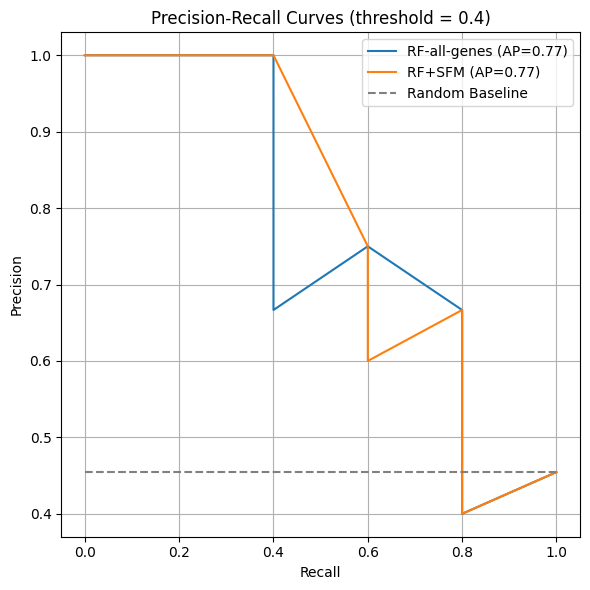

In [14]:
# STEP ───────────────────────────────────────────────────────────────
# Evaluate BOTH Random-Forest models with a probability threshold = 0.4

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def evaluate_with_threshold(model, X, y, label):
    """
    Predict with proba, apply threshold=0.4, and print metrics.
    Returns dict with key results for tabular comparison later.
    """
    proba = model.predict_proba(X)[:, 1]                 # P(cancer)
    preds = (proba >= 0.4).astype(int)                   # threshold = 0.4
    
    print(f"\n=== {label} (threshold 0.4) ===")
    print(classification_report(y, preds, target_names=["Healthy", "Cancer"]))
    
    roc_auc = roc_auc_score(y, proba)
    pr_auc  = average_precision_score(y, proba)
    print(f"ROC-AUC: {roc_auc:.4f}   PR-AUC: {pr_auc:.4f}")
    
    # Optionally plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y, proba)
    plt.plot(recall, precision, label=f"{label} (AP={pr_auc:.2f})")
    return {"model": label, "roc_auc": roc_auc, "pr_auc": pr_auc}

plt.figure(figsize=(6,6))

results = []
results.append(evaluate_with_threshold(grid_rf,      X_test, y_test, "RF-all-genes"))
results.append(evaluate_with_threshold(grid_rf_sfm,  X_test, y_test, "RF+SFM"))

# baseline line for random classifier in PR space
plt.hlines(y=sum(y_test)/len(y_test), xmin=0, xmax=1, ls="--", color="gray", label="Random Baseline")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curves (threshold = 0.4)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## 🚀 Model 4: XGBoost Classifier (Boosting)
We'll now train an XGBoost classifier to predict colon cancer.
This model uses boosting — training many trees in sequence, each correcting the previous one.
We’ll tune key hyperparameters using GridSearchCV and evaluate its performance on the test set.


In [15]:
# STEP 2 ──────────────────────────────────────────────────────────────
# Build pipeline for XGBoost classifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline


# Initialize base XGBoost classifier (we’ll tune it later)
xgb_clf = XGBClassifier(
    use_label_encoder=False,       # avoids warning in sklearn
    eval_metric='logloss',         # necessary for compatibility
    random_state=42                # reproducibility
)

# Simple pipeline: you can add feature selection later
xgb_pipe = Pipeline([
    ('clf', xgb_clf)
])

xgb_pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [16]:
# STEP 3 ──────────────────────────────────────────────────────────────
# Define hyperparameter grid for XGBoost

from sklearn.model_selection import GridSearchCV, StratifiedKFold

xgb_param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],  #How much each tree corrects the previous one
    'clf__max_depth': [3, 5, 7],
    'clf__subsample': [0.8],       #Fraction of samples used in each boosting round
    'clf__colsample_bytree': [0.8]  #Fraction of features used in each tree
}

# 5-fold stratified CV
xgb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with ROC-AUC scoring
grid_xgb = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=xgb_cv,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_xgb.fit(X_train, y_train)

# Print best results
print("Best parameters:", grid_xgb.best_params_)
print("Best cross-validated ROC-AUC score:", grid_xgb.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:59:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
Best cross-validated ROC-AUC score: 0.845


=== XGBoost (threshold 0.5) ===
              precision    recall  f1-score   support

     Healthy       0.67      1.00      0.80         6
      Cancer       1.00      0.40      0.57         5

    accuracy                           0.73        11
   macro avg       0.83      0.70      0.69        11
weighted avg       0.82      0.73      0.70        11

Test ROC-AUC: 0.7833


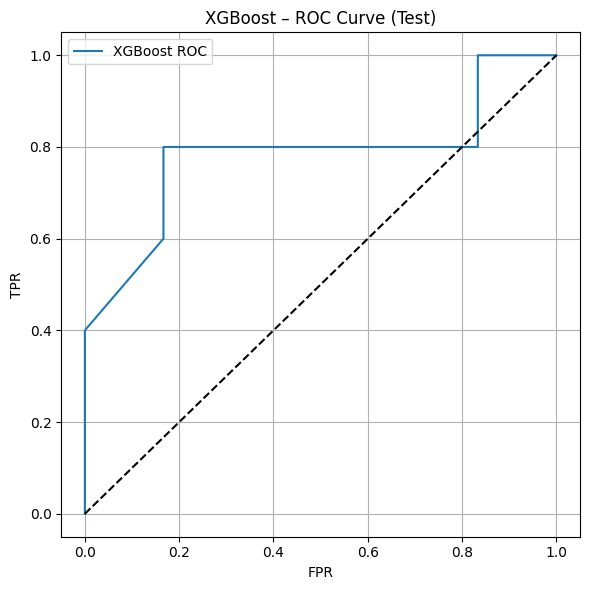

In [17]:
# STEP 4 ──────────────────────────────────────────────────────────────
# Evaluate the best XGBoost model on the test set

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ---------- Default threshold (0.5) ----------
y_pred_xgb = grid_xgb.predict(X_test)
y_proba_xgb = grid_xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost (threshold 0.5) ===")
print(classification_report(y_test, y_pred_xgb, target_names=["Healthy", "Cancer"]))
print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba_xgb), 4))

fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="XGBoost ROC")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("XGBoost – ROC Curve (Test)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()




=== XGBoost (threshold 0.4) ===
              precision    recall  f1-score   support

     Healthy       0.71      0.83      0.77         6
      Cancer       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11

Test ROC-AUC (probability-based): 0.7833333333333334


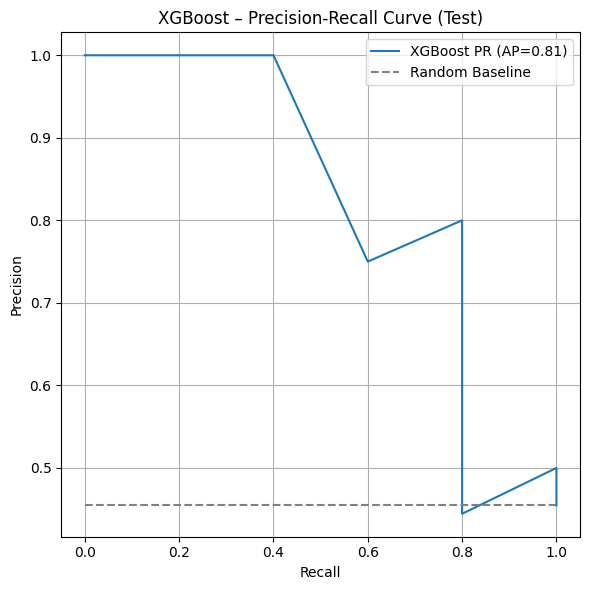

In [18]:
# ---------- Custom threshold (0.4) ----------
thr = 0.4
y_pred_thr = (y_proba_xgb >= thr).astype(int)

print(f"\n=== XGBoost (threshold {thr}) ===")
print(classification_report(y_test, y_pred_thr, target_names=["Healthy", "Cancer"]))
print("Test ROC-AUC (probability-based):", roc_auc_score(y_test, y_proba_xgb))


pr_auc = average_precision_score(y_test, y_proba_xgb)
prec, rec, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f"XGBoost PR (AP={pr_auc:.2f})")
plt.hlines(sum(y_test)/len(y_test), 0, 1, ls="--", color="gray", label="Random Baseline")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("XGBoost – Precision-Recall Curve (Test)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


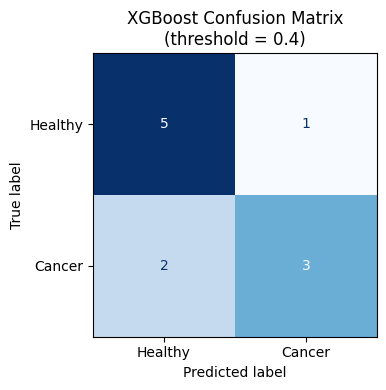

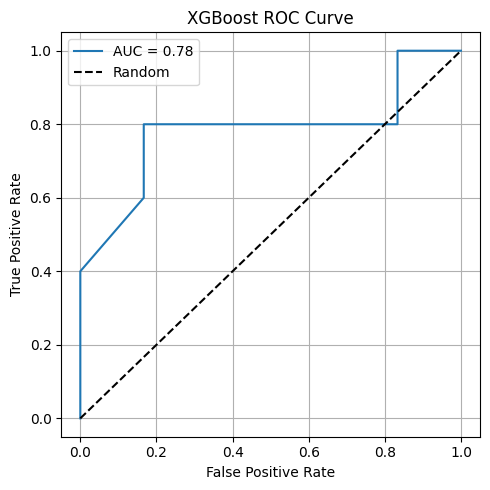

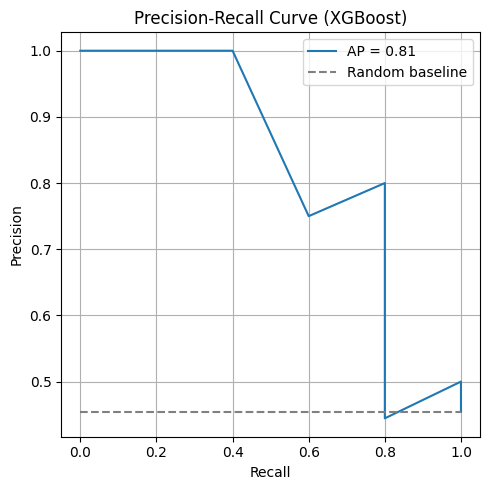

C:\Users\HP\AppData\Local\Temp\ipykernel_10544\1960466733.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, ax=ax_imp, palette="viridis")


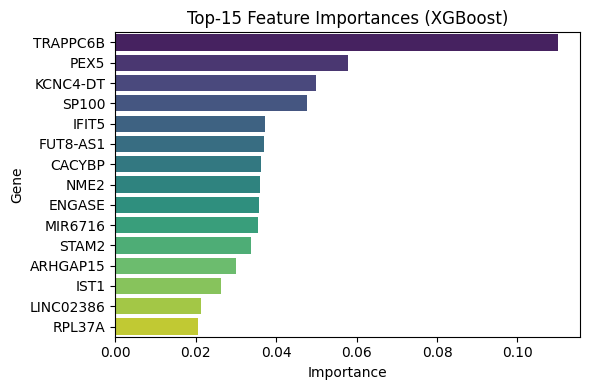

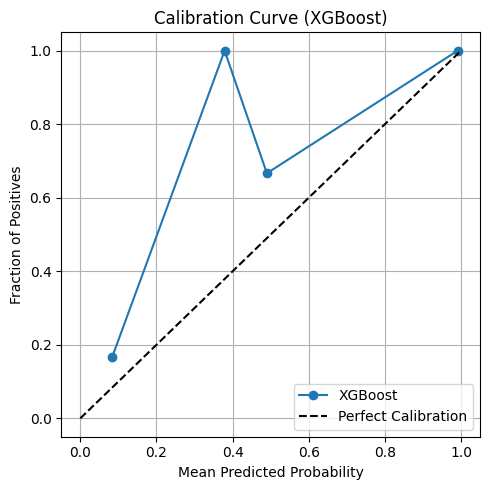

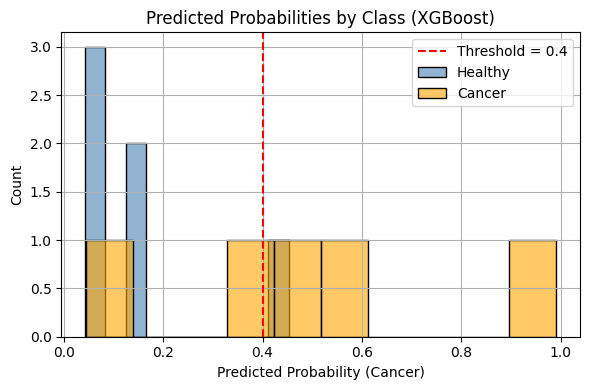

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve,
    average_precision_score, roc_auc_score
)

# ─── Ensure y_proba_xgb exists ──────────────────────────────
# If not already defined:
try:
    y_proba_xgb
except NameError:
    y_proba_xgb = grid_xgb.predict_proba(X_test)[:, 1]

thr = 0.4  # chosen threshold
y_pred_thr = (y_proba_xgb >= thr).astype(int)

# ─────────────────────────────────────────────────────────────
# 1) Confusion Matrix
cm = confusion_matrix(y_test, y_pred_thr)
disp = ConfusionMatrixDisplay(cm, display_labels=["Healthy", "Cancer"])
fig_cm, ax_cm = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax_cm, cmap="Blues", colorbar=False, values_format="d")
ax_cm.set_title("XGBoost Confusion Matrix\n(threshold = 0.4)")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 2) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
roc_auc = roc_auc_score(y_test, y_proba_xgb)

fig_roc, ax_roc = plt.subplots(figsize=(5, 5))
ax_roc.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
ax_roc.plot([0, 1], [0, 1], "k--", label="Random")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("XGBoost ROC Curve")
ax_roc.legend()
ax_roc.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 3) Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = average_precision_score(y_test, y_proba_xgb)

fig_pr, ax_pr = plt.subplots(figsize=(5, 5))
ax_pr.plot(recall, precision, label=f"AP = {pr_auc:.2f}")
ax_pr.hlines(sum(y_test)/len(y_test), 0, 1, ls="--", color="gray", label="Random baseline")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Precision‑Recall Curve (XGBoost)")
ax_pr.legend()
ax_pr.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 4) Top‑15 Feature Importances
booster = grid_xgb.best_estimator_.named_steps["clf"]
importances = pd.Series(booster.feature_importances_, index=X_test.columns)
top15 = importances.sort_values(ascending=False).head(15)

fig_imp, ax_imp = plt.subplots(figsize=(6, 4))
sns.barplot(x=top15.values, y=top15.index, ax=ax_imp, palette="viridis")
ax_imp.set_title("Top‑15 Feature Importances (XGBoost)")
ax_imp.set_xlabel("Importance")
ax_imp.set_ylabel("Gene")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 5) Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_xgb, n_bins=5, strategy="uniform")

fig_cal, ax_cal = plt.subplots(figsize=(5, 5))
ax_cal.plot(prob_pred, prob_true, marker="o", label="XGBoost")
ax_cal.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
ax_cal.set_xlabel("Mean Predicted Probability")
ax_cal.set_ylabel("Fraction of Positives")
ax_cal.set_title("Calibration Curve (XGBoost)")
ax_cal.legend()
ax_cal.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 6) Predicted Probability Histogram
fig_hist, ax_hist = plt.subplots(figsize=(6, 4))
sns.histplot(y_proba_xgb[y_test == 0], color="steelblue", label="Healthy", bins=10, alpha=0.6)
sns.histplot(y_proba_xgb[y_test == 1], color="orange", label="Cancer", bins=10, alpha=0.6)
ax_hist.axvline(thr, color="red", ls="--", label=f"Threshold = {thr}")
ax_hist.set_xlabel("Predicted Probability (Cancer)")
ax_hist.set_ylabel("Count")
ax_hist.set_title("Predicted Probabilities by Class (XGBoost)")
ax_hist.legend()
ax_hist.grid(True)
plt.tight_layout()
plt.show()


## 🏗️ Model 5: Stacking Classifier (Ensemble of LogReg + Random Forest + XGBoost)
We’ll blend the three tuned base models into a StackingClassifier,
then train a simple meta-model to learn how to combine their predictions.


In [20]:
# STEP 2 ──────────────────────────────────────────────────────────────
# Define base models and meta-model for Stacking

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Base models with best hyperparameters found previously
base_lr = LogisticRegression(C=0.1, max_iter=1000, random_state=42)

base_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42
)

base_xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Meta-model to learn from base model predictions
meta_model = LogisticRegression(random_state=42)


In [21]:
# STEP 3 ──────────────────────────────────────────────────────────────
# Build the stacking pipeline and train it on training data

from sklearn.pipeline import Pipeline

# Define base learners for stacking
estimators = [
    ('lr', base_lr),
    ('rf', base_rf),
    ('xgb', base_xgb)
]

# Define stacking classifier with logistic regression as meta-learner
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False,        # if True, passes original features too to meta-model
    verbose=1
)

# Wrap in a pipeline (optional, good for future extensibility)
stacking_pipe = Pipeline([
    ('clf', stacking_clf)
])

# Fit the pipeline on the training data
stacking_pipe.fit(X_train, y_train)


Pipeline(steps=[('clf',
                 StackingClassifier(cv=5,
                                    estimators=[('lr',
                                                 LogisticRegression(C=0.1,
                                                                    max_iter=1000,
                                                                    random_state=42)),
                                                ('rf',
                                                 RandomForestClassifier(min_samples_leaf=2,
                                                                        random_state=42)),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=0.8,
                                                               device=None,
                                                               early_stopping_roun...
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=300,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1, verbose=1))])

=== Stacking Classifier (threshold = 0.5) ===
              precision    recall  f1-score   support

     Healthy       0.67      1.00      0.80         6
      Cancer       1.00      0.40      0.57         5

    accuracy                           0.73        11
   macro avg       0.83      0.70      0.69        11
weighted avg       0.82      0.73      0.70        11

Test ROC-AUC: 0.75


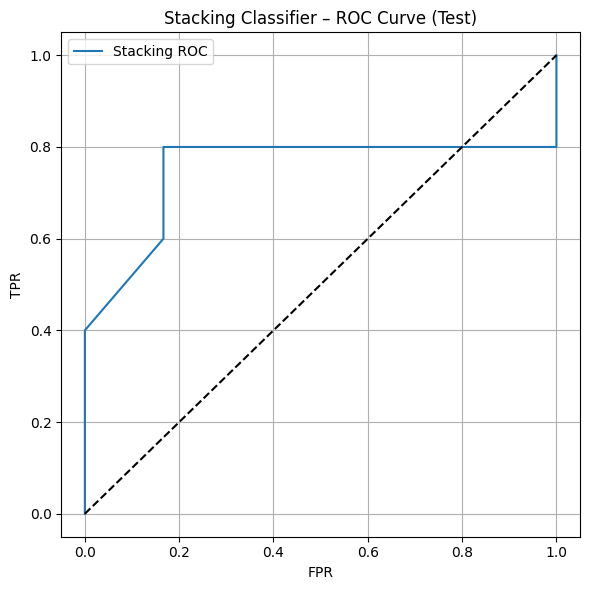

In [22]:
# STEP 4 ──────────────────────────────────────────────────────────────
# Evaluate StackingClassifier on the test set (threshold = 0.5)

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities and labels
y_proba_stack = stacking_pipe.predict_proba(X_test)[:, 1]
y_pred_stack = stacking_pipe.predict(X_test)

# Print classification report
print("=== Stacking Classifier (threshold = 0.5) ===")
print(classification_report(y_test, y_pred_stack, target_names=["Healthy", "Cancer"]))

# ROC-AUC score
print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba_stack), 4))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="Stacking ROC")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Stacking Classifier – ROC Curve (Test)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


=== Stacking Classifier (threshold = 0.4) ===
              precision    recall  f1-score   support

     Healthy       0.71      0.83      0.77         6
      Cancer       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11

ROC-AUC (probability-based): 0.75


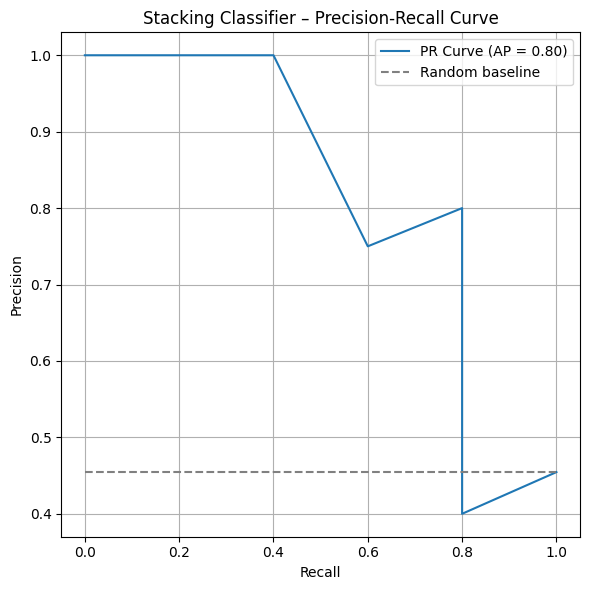

In [23]:
# STEP 5 ──────────────────────────────────────────────────────────────
# Adjust threshold to 0.4 and re-evaluate StackingClassifier

from sklearn.metrics import precision_recall_curve, average_precision_score

# Custom threshold
threshold = 0.4
y_pred_thr_stack = (y_proba_stack >= threshold).astype(int)

print(f"=== Stacking Classifier (threshold = {threshold}) ===")
print(classification_report(y_test, y_pred_thr_stack, target_names=["Healthy", "Cancer"]))

# ROC-AUC stays the same (since it's threshold-independent)
print("ROC-AUC (probability-based):", round(roc_auc_score(y_test, y_proba_stack), 4))

# PR Curve + AUC
pr_auc = average_precision_score(y_test, y_proba_stack)
prec, rec, _ = precision_recall_curve(y_test, y_proba_stack)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.hlines(sum(y_test)/len(y_test), 0, 1, ls="--", color="gray", label="Random baseline")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Stacking Classifier – Precision-Recall Curve")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


SUMMARY OF ALL THE MODELS DONE YET

In [24]:
# -------------------------------------------------------------------
# SUMMARY COMPARISON OF ALL MODELS & THRESHOLDS  +  CV ROC-AUC column
# -------------------------------------------------------------------

import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    accuracy_score
)

def evaluate(model, X, y, thr=0.5, name="model", cv_auc=None):
    """Return dict of core metrics at given threshold, incl. CV ROC-AUC."""
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= thr).astype(int)
    return {
        "Model": name,
        "Threshold": thr,
        "Accuracy": accuracy_score(y, preds),
        "Cancer_Precision": precision_score(y, preds),
        "Cancer_Recall": recall_score(y, preds),
        "Cancer_F1": f1_score(y, preds),
        "Test_ROC_AUC": roc_auc_score(y, proba),
        "CV_ROC_AUC": cv_auc
    }

results = []

# helpers to fetch best CV score safely
cv_lr   = grid.best_score_
cv_rf   = grid_rf.best_score_
cv_rfs  = grid_rf_sfm.best_score_
cv_xgb  = grid_xgb.best_score_
cv_stack = None   # replace with cross_val_score if you compute it later

# 1. Logistic Regression
results.append(evaluate(grid.best_estimator_, X_test, y_test, 0.5, "LogReg (0.5)", cv_lr))
results.append(evaluate(grid.best_estimator_, X_test, y_test, 0.4, "LogReg (0.4)", cv_lr))

# 2. Random Forest (all genes)
results.append(evaluate(grid_rf.best_estimator_, X_test, y_test, 0.5, "RF-all (0.5)", cv_rf))
results.append(evaluate(grid_rf.best_estimator_, X_test, y_test, 0.4, "RF-all (0.4)", cv_rf))

# 3. Random Forest + SFM
results.append(evaluate(grid_rf_sfm.best_estimator_, X_test, y_test, 0.5, "RF+SFM (0.5)", cv_rfs))
results.append(evaluate(grid_rf_sfm.best_estimator_, X_test, y_test, 0.4, "RF+SFM (0.4)", cv_rfs))

# 4. XGBoost
results.append(evaluate(grid_xgb.best_estimator_, X_test, y_test, 0.5, "XGB (0.5)", cv_xgb))
results.append(evaluate(grid_xgb.best_estimator_, X_test, y_test, 0.4, "XGB (0.4)", cv_xgb))

# 5. Stacking
results.append(evaluate(stacking_pipe, X_test, y_test, 0.5, "Stacking (0.5)", cv_stack))
results.append(evaluate(stacking_pipe, X_test, y_test, 0.4, "Stacking (0.4)", cv_stack))

# Create DataFrame and sort by Test ROC-AUC
summary_df = (
    pd.DataFrame(results)
      .sort_values(by="Test_ROC_AUC", ascending=False)
      .reset_index(drop=True)
)

summary_df


,Model,Threshold,Accuracy,Cancer_Precision,Cancer_Recall,Cancer_F1,Test_ROC_AUC,CV_ROC_AUC
0,XGB (0.5),0.5,0.727273,1.000000,0.4,0.571429,0.783333,0.8450
1,XGB (0.4),0.4,0.727273,0.750000,0.6,0.666667,0.783333,0.8450
2,Stacking (0.5),0.5,0.727273,1.000000,0.4,0.571429,0.750000,NaN
3,Stacking (0.4),0.4,0.727273,0.750000,0.6,0.666667,0.750000,NaN
4,RF-all (0.5),0.5,0.727273,1.000000,0.4,0.571429,0.716667,0.8075
5,RF-all (0.4),0.4,0.636364,0.666667,0.4,0.500000,0.716667,0.8075
6,RF+SFM (0.5),0.5,0.727273,1.000000,0.4,0.571429,0.716667,0.8225
7,RF+SFM (0.4),0.4,0.636364,0.600000,0.6,0.600000,0.716667,0.8225
8,LogReg (0.5),0.5,0.727273,1.000000,0.4,0.571429,0.716667,0.8525
9,LogReg (0.4),0.4,0.636364,0.600000,0.6,0.600000,0.716667,0.8525


In [25]:
import joblib


best_model = grid_xgb.best_estimator_

# Save the model
joblib.dump(best_model, "xgb_model_thresh_0.4.pkl")



['xgb_model_thresh_0.4.pkl']